# CHUYỂN ĐỔI DỮ LIỆU VỀ PHÂN PHỐI CHUẨN

Nhiều phép kiểm định thống kê và một số thuật toán machine learning giả định biến số liên tục tuân theo phân phối chuẩn tuy nhiên thực tế không phải lúc nào dữ liệu thu được đều thỏa mãn điều kiện này. Chính vì thế chúng ta cần chuyển đổi dữ liệu chưa tuân theo định luật về phân phối chuẩn (hoặc gần giống như vậy). Một số phương pháp để thực hiện phép chuyển đổi này như:
- Logarit hóa (cơ số e, 2, 10, ...): Khi độ xiên (skew) vừa phải và biến số không âm. 
- Căn thức (bậc e, 2, 3, ...): Khi độ xiên (skew) lớn.  
- Nghịch đảo (1/x, ..): Khi độ xiên (skew) rất lớn.  

__Lưu ý:__ Nếu lệch phải (skew > 0, Mode < Median < Mean) thì phép chuyển trực tiếp với x, ví dụ: log(x). Nếu lệch trái (skew < 0, Mode > Median > Mean) thì phép chuyển với (max(x) + 1) - x, ví dụ: log((max(x) + 1) - x). 
  
Một số phép chuyển khác tham khảo từ [Applied Multivariate Statistics for the Social Sciences](http://docshare02.docshare.tips/files/31719/317194846.pdf):
  
![](images/trainsform_for_normal_distribution.png)

## Mô phỏng cho bộ dữ liệu

In [1]:
import numpy as np
import pandas as pd
# Tạo biến x1
x1= np.random.lognormal(size= 300, mean= 1)
# Tạo biến x2
x2= np.random.lognormal(size= 300, mean= 1)
x2= (x2.max() + 1) - x2
# Tạo biến y
y= np.random.choice([0, 1], size=300, p=[.5, .5])
# Tạo data frame
data= np.concatenate((x1.reshape(-1,1), x2.reshape(-1,1), y.reshape(-1,1)), axis=1)
data= pd.DataFrame(data, columns= ['x1', 'x2', 'y'])

Text(0.5, 1.0, 'x2 - lệch trái')

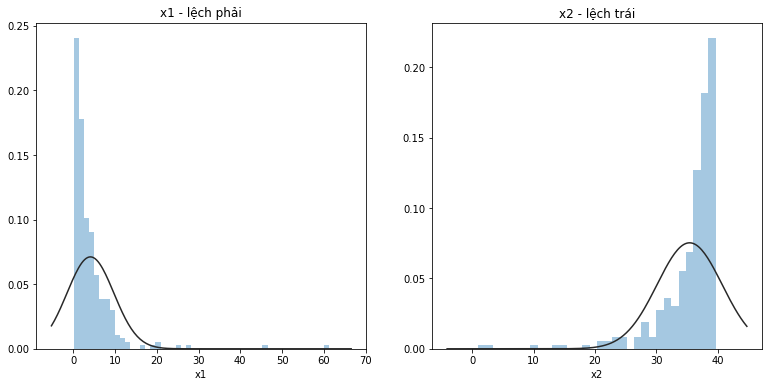

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

fig = plt.figure(figsize= (13, 6))
plt.subplot(1, 2, 1)
sns.distplot(data.x1, fit=norm, kde=False)
plt.title('x1 - lệch phải')

plt.subplot(1, 2, 2)
sns.distplot(data.x2, fit=norm, kde=False)
plt.title('x2 - lệch trái')

## 1. Chuyển đổi dữ liệu bằng Numpy và Pandas

### 1.1. Chuyển đổi biến x1

Text(0.5, 1.0, 'x1_log')

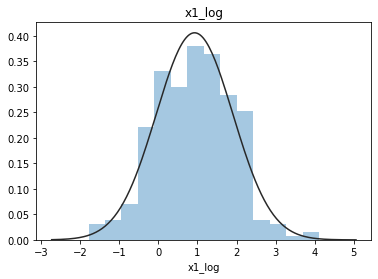

In [6]:
# Logarit hóa
data['x1_log']= np.log(data['x1'])
sns.distplot(data['x1_log'], fit=norm, kde=False)
plt.title('x1_log')

Text(0.5, 1.0, 'x1_sqrt')

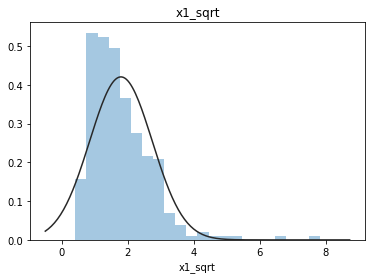

In [7]:
# Căn bậc hai
data['x1_sqrt']= np.sqrt(data['x1'])
sns.distplot(data['x1_sqrt'], fit=norm, kde=False)
plt.title('x1_sqrt')

### 1.2 Chuyển đổi biến x2

Text(0.5, 1.0, 'x2_log')

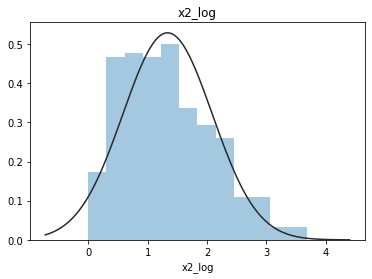

In [8]:
# Logarit hóa
data['x2_log']= np.log((data['x2'].max() + 1) - data['x2'])
sns.distplot(data['x2_log'], fit=norm, kde=False)
plt.title('x2_log')

Text(0.5, 1.0, 'x2_sqrt')

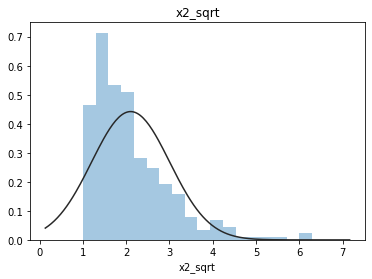

In [9]:
# Căn bậc hai
data['x2_sqrt']= np.sqrt((data['x2'].max() + 1) - data['x2'])
sns.distplot(data['x2_sqrt'], fit=norm, kde=False)
plt.title('x2_sqrt')

## 2. Chuyển đổi dữ liệu bằng Scikit-Learn

### 2.1. Sử dụng FunctionTransformer

Đối với phép chuẩn hóa dữ liệu bị lệch trái thì trường hợp dữ liệu test (hoặc khi dự đoán thực tế) xảy ra trường hợp biến số chuẩn hóa có giá trị lớn hơn max của giá trị hiện tại do đó cần giới hạn nếu giá trị test lớn hơn max của tập train thì gán bằng max của tập trại và nhỏ hơn min của tập train thì gán bằng min của tập train. Nếu dữ liệu train đủ đại diện thì trường hợp này cũng không có sự chênh lệch đáng kể.

In [11]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Chuẩn hóa biến lệch phải
log_transformer = FunctionTransformer(np.log)

# Chuẩn hóa biến lệch trái
# Kết hợp min max scaler
remove_out_of_range_x2= MinMaxScaler(feature_range= (data['x2'].min(), data['x2'].max()))
# Đảo chiều từ lệch phải sang lệch trái
reverse_x2_transformer= FunctionTransformer(lambda x: (x + 1).max() - x)
# Pipe chuẩn hóa biến lệch trái
normalize_from_left_skewed= Pipeline(steps= [
    ('Remove x2 out of range', remove_out_of_range_x2),
    ('Reverse', reverse_x2_transformer),
    ('Logarit', log_transformer)])

# ColumnTransformer cho biến x1 x2
col_transfom_v1= ColumnTransformer(transformers= [('Normalize from right skewed', log_transformer, ['x1']),
                                                 ('Normalize from left skewed', normalize_from_left_skewed, ['x2'])])
# Fit
col_transfomer_v1= col_transfom_v1.fit(data)
# Transform data
data_new_v1= col_transfomer_v1.transform(data)

In [12]:
def make_plot(data):
    fig = plt.figure(figsize= (13, 6))
    plt.subplot(1, 2, 1)
    sns.distplot(data[:,0], fit=norm, kde=False)
    plt.title('x1_transformed')

    plt.subplot(1, 2, 2)
    sns.distplot(data[:,1], fit=norm, kde=False)
    plt.title('x2_transformed')

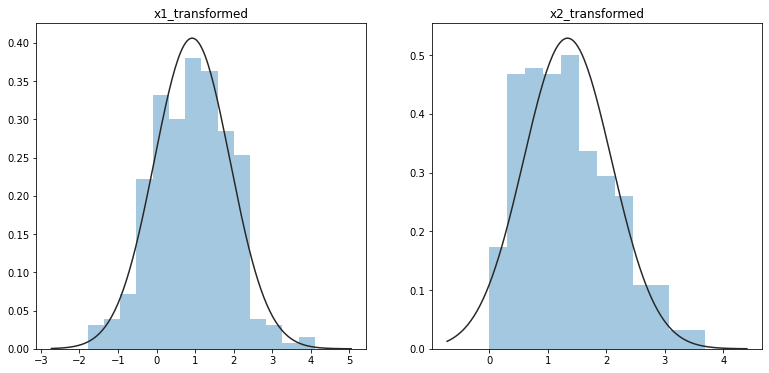

In [13]:
make_plot(data_new_v1)

Trong Scikit-Learn còn hỗ trợ 2 phương thức để chuyển đổi dữ liệu về phân phối chuẩn đó là PowerTransformer và QuantileTransformer

### 2.2. Sử dụng PowerTransformer

In [14]:
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer

bc_power_transformer = PowerTransformer(method='box-cox') # hoặc yeo-johnson

# ColumnTransformer cho biến x1 x2
col_transfom_v2= ColumnTransformer(transformers= [('Normalize from right skewed', bc_power_transformer, ['x1']),
                                                 ('Normalize from left skewed', bc_power_transformer, ['x2'])])
# Fit
col_transfomer_v2= col_transfom_v2.fit(data)
# Transform data
data_new_v2= col_transfomer_v2.transform(data)

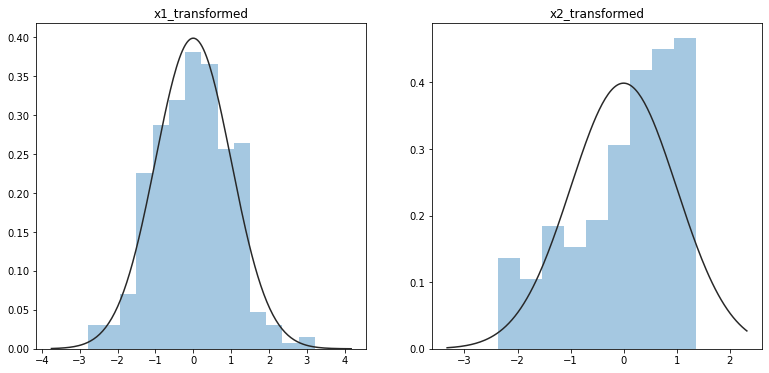

In [15]:
make_plot(data_new_v2)

### 2.3. Sử dụng QuantileTransformer

In [16]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer

qantile_transformer = QuantileTransformer(output_distribution='normal')

# ColumnTransformer cho biến x1 x2
col_transfom_v3= ColumnTransformer(transformers= [('Normalize from right skewed', qantile_transformer, ['x1']),
                                                 ('Normalize from left skewed', qantile_transformer, ['x2'])])
# Fit
col_transfomer_v3= col_transfom_v3.fit(data)
# Transform data
data_new_v3= col_transfomer_v3.transform(data)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (300). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


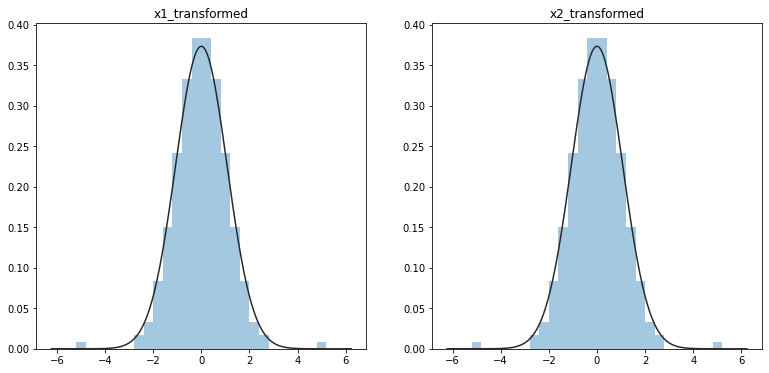

In [17]:
make_plot(data_new_v3)